## Lab 3
### Part 1: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print("Directory", path, "is created!")
    else:
        print("Directory", path, "already exists!")


root_path = "fmnist"
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(
    root_path, train=True, transform=train_transform, target_transform=None, download=download
)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(
    root_path, train=False, transform=test_transform, target_transform=None, download=download
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.3MB/s]


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.87MB/s]


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 26.9MB/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [4]:
train_loader = torch.utils.data.DataLoader(
    fmnist_dataset_train, batch_size=128, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    fmnist_dataset_test, batch_size=256, shuffle=False, num_workers=2
)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
    #     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [19]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28 * 28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes),
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [11]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
              ReLU-6                  [-1, 256]               0
           Dropout-7                  [-1, 256]               0
            Linear-8                   [-1, 10]           2,570
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.04
Estimated Total Size (MB): 2.07
----------------------------------------------------------------


Your experiments come here:

Epoch [20/20]
Train Loss: 0.2209, Train Accuracy: 0.9157
Val Loss: 0.3148, Val Accuracy: 0.8911


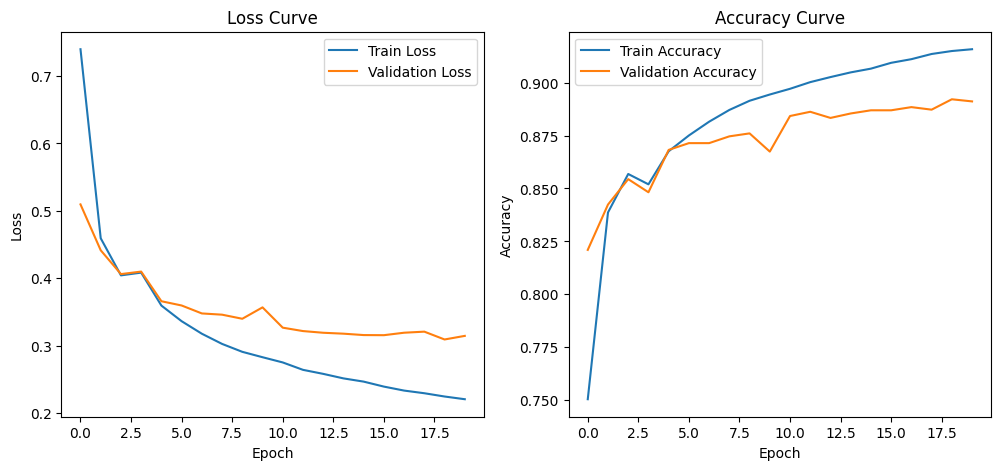

In [22]:
import time

model = TinyNeuralNetwork().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE
scheduler = torch.optim.lr_scheduler.ConstantLR(opt, factor=0.2, total_iters=3)

# Training and Validation Loops
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        opt.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        opt.step()

        epoch_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = epoch_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_func(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= total
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step()

    clear_output(wait=True)
    print(f"Epoch [{epoch + 1}/{num_epochs}]\n"
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}\n"
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

Я использовала три полносвязных слоя, также я использовала ReLU, чтобы избежать проблемы затухающих градиентов, и для снижения риска переобучения поставила dropout 0.2. Размер батча я выставила 128, вроде этого хватает, но при этом GPU не перегружается. Также вначале я поставила 10 эпох, но мне этого не хватало для достижения подходящего accuracy, поэтому я поставила 20 эпах, сейчас в самый раз. На графиках видно, что train loss последовательно уменьшается, но вот validation loss на начальных эпохах падает, а затем стабилизируется и начинает слегка увеличиваться, что говорит о возможном начале переобучения после 10-12 эпох. Также признаком переобучения является график validation accuracy, который также стабилизируется и начинает отставать от тренировочной точности после 12 эпох. Тем не менее, нужные значения точности получены.

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [31]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28 * 28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 2048),  # Increased network complexity
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [26]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
              ReLU-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
              ReLU-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
              ReLU-7                  [-1, 256]               0
            Linear-8                  [-1, 128]          32,896
              ReLU-9                  [-1, 128]               0
           Linear-10                   [-1, 10]           1,290
Total params: 1,494,154
Trainable params: 1,494,154
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 5.70
Estimat

Epoch [100/100]
Train Loss: 0.2898, Train Accuracy: 0.8978
Test Loss: 0.4276, Test Accuracy: 0.8718


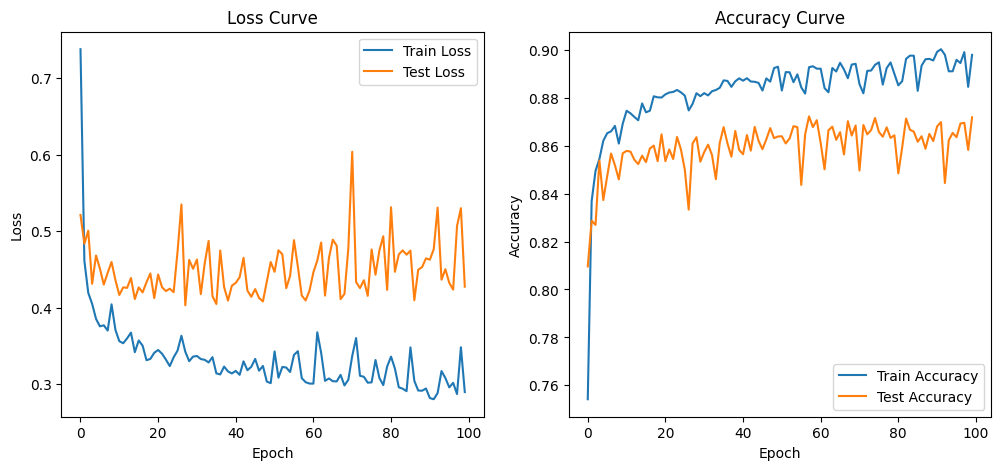

In [33]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01)  # Increased learning rate to worsen overfitting
loss_func = nn.CrossEntropyLoss()

num_epochs = 100
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        opt.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        opt.step()

        train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_losses.append(train_loss / total)
    train_accuracies.append(correct / total)

    model.eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_func(outputs, labels)
            test_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_losses.append(test_loss / total)
    test_accuracies.append(correct / total)

    clear_output(wait=True)
    print(f"Epoch [{epoch + 1}/{num_epochs}]\n"
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}\n"
          f"Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}")

figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

Я уменьшила размер тренировочного набора до 500 образцов и сделала строение сети более сложной (изменила слои: 2048→1024→512→256 и
увеличила количество скрытых слоев (4 вместо 2) и число нейронов на каждом слое). Также я убрала dropout и повысила скорость обучения (lr=0.01).

На графиках явно видно, что модель переобучилась: модель обучается слишком хорошо на тренировочных данных, но плохо обобщает результаты на тестовых. Виден растущий разрыв между тренировочной и тестовой метриками. Если говорить конкретнее про графики, можно сделать следующие замечания: Train Loss постепенно уменьшается и достигает очень низкого значения (0.2898). Видно, что модель очень хорошо адаптировалась к тренировочным данным. Но вот
Test Loss остаётся высоким и нестабильным, с колебаниями в процессе обучения. Train Accuracy достигла 0.8978, и это очень высокая точность, практически идеальная для обучения на тренировочных данных.
Но вот Test Accuracy остановилась на 0.8718 и больше не улучшалась после определенного момента. При этом можно видеть явный разрыв между тренировочной и тестовой точностью, и это тоже является признаком переобучения.


### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [28]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28 * 28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [29]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
       BatchNorm1d-3                 [-1, 1024]           2,048
              ReLU-4                 [-1, 1024]               0
           Dropout-5                 [-1, 1024]               0
            Linear-6                  [-1, 512]         524,800
       BatchNorm1d-7                  [-1, 512]           1,024
              ReLU-8                  [-1, 512]               0
           Dropout-9                  [-1, 512]               0
           Linear-10                  [-1, 256]         131,328
      BatchNorm1d-11                  [-1, 256]             512
             ReLU-12                  [-1, 256]               0
          Dropout-13                  [-1, 256]               0
           Linear-14                  [

Epoch [20/20]
Train Loss: 0.2608, Train Accuracy: 0.9058
Test Loss: 0.3165, Test Accuracy: 0.8867


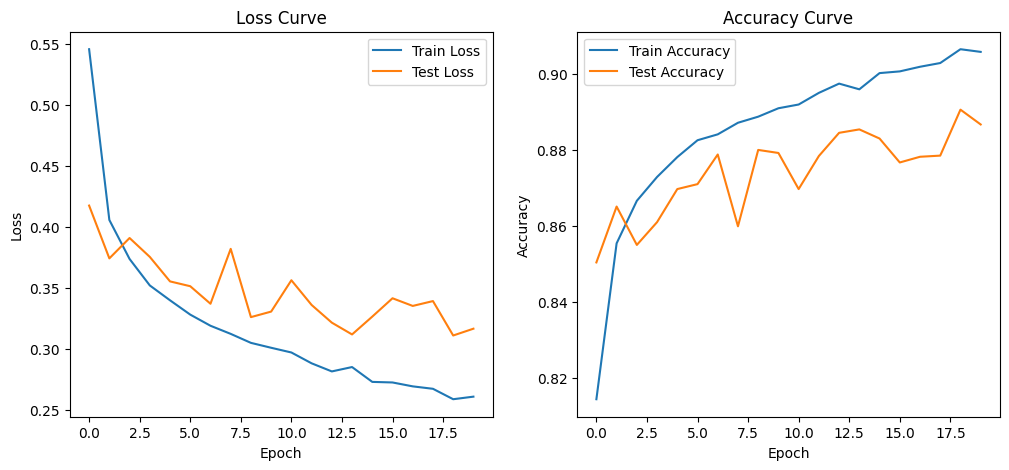

In [30]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Added weight decay for regularization
loss_func = nn.CrossEntropyLoss()

num_epochs = 20
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        opt.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        opt.step()

        train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_losses.append(train_loss / total)
    train_accuracies.append(correct / total)

    model.eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_func(outputs, labels)
            test_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_losses.append(test_loss / total)
    test_accuracies.append(correct / total)

    clear_output(wait=True)
    print(f"Epoch [{epoch + 1}/{num_epochs}]\n"
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}\n"
          f"Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}")

figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()


Я добавила регуляризацию в сеть с использованием
batch normalization, dropout я поставила равным 0.3, и также использовала регуляризацию L2 через параметр weight_decay в оптимизаторе. Регуляризация снизила переобучение, но не устранила его полностью. Чтобы улучшить модель еще больше, можно увеличить размер тренировочного набора,
включить early stopping, еще можно продолжить экспериментировать с коэффициентом dropout или добавить larger dropout на начальных слоях.

### Conclusions:
_Write down small report with your conclusions and your ideas._

Цель первого задания заключалась в том, чтобы обучить нейронную сеть на Fashion-MNIST и достичь определённой точности на тестовой выборке, затем надо было продемонстрировать переобучение модели, ну а после этого попытаться "улучшить модель", то есть применить техники регуляризации для уменьшения переобучения. Переобучение видно как на графиках, так и на значениях accuracy. Как локальный вывод - не стоит слишком усложнять модель и слишком увеличивать количество эпох, это может привести к проблемам, как тут. Промежуточные выводы в целом дают полную картину происходящего в задании. Из идей - поэксперементировать еще с data augmentation и еще поподбирать гиперпараметры.